# 1. What factors contribute to the price of an Airbnb listing?

## Data Cleaning and Preparation

In [6]:
import pandas as pd 
import sklearn.preprocessing
import numpy as np
from collections import Counter

# define a data preprocessing process
def preprocess_data(df):
    """
    Preprocess and clean the listings data.

    Args:
        df (pd.DataFrame): Airbnb listings data.
    
    Returns:
        df (pd.DataFrame): Cleaned listings data.
    """

    df = proc_numerical(df)

    df = proc_date(df)

    df = proc_binary(df)

    df = encode_cat(df)

    df = encode_amenities(df)

    df = drop_cols(df)

    return df


def proc_numerical(df):
    """
    Converts price and rate columns in listings data to floats.

    Args:
        df (pd.DataFrame): Airbnb listings data.
    
    Returns:
        df (pd.DataFrame): Airbnb listings data with price and rate converted to float.

    Note:
    check https://www.ritchieng.com/pandas-changing-datatype/ for more info about this processing.
    """
    # Convert price to float ($100,000 -> 100000)
    if df['price'].dtype == 'object':
        df['price'] = df['price'].str.lstrip('$').str.replace(',', '')
        df['price'] = df['price'].astype(float)

    for col in ['host_response_rate', 'host_acceptance_rate']:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('%', '')
            df[col] = df[col].astype(float)

    return df


def proc_date(df):
    """
    Convert date in string format to a datetime object.

    Args:
        df (pd.DataFrame): Airbnb listings data.

    Returns:
        df (pd.DataFrame): Airbnb listings data with date as datatime object.

    """
    date_columns = ['host_since', 'first_review', 'last_review']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])

    return df

def proc_binary(df):
    """
    Encode binary columns using sklearn LabelEncoder (0, 1)

    Args:
        df (pd.DataFrame): Airbnb listings data.
    
    Returns:
        df (pd.DataFrame): Airbnb listings data with binary data encoded to 0 or 1.

    """
    binary_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',  'instant_bookable', 'has_availability']
    for col in binary_cols:
        df[col] = sklearn.preprocessing.LabelEncoder().fit_transform(df[col])

    return df

def encode_cat(df):
    """
    Encode categorical columns (neighbourhood_cleansed, property_type, room_type) and bathrooms_text.

    Args:
        df (pd.DataFrame): Airbnb listings data.

    Retuns:
        df (pd.DataFrame): Airbnb listings data with encoded categorical columns and processed text into usable numbers.

    """
    def encode_cat_col(df, col):
        """
        Encode a column using One hot encoder.

        Args:
            df (pd.DataFrame): Data containing categorical columns.
            col (str): The column to encode 
        
        Returns:
            col_encoded_df (pd.DataFrame): Dataframe containing encoded column

        """
        label_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
        col_encoded = label_encoder.fit_transform(df[[col]])
        col_encoded_df = pd.DataFrame(col_encoded, columns=label_encoder.get_feature_names_out([col]))
        return col_encoded_df
    
    def parse_bathroom_text(txt_str):
        """
        Parse text string to get the number of bathrooms in a listing.

        Args:
            txt_str (str): Text string containing bathroom information
        
        Returns:
            baths (tuple): Tuple containing number of bathrooms and shared bathrooms

        """
        if pd.isna(txt_str):
            baths = np.nan, np.nan
        else:
            text = txt_str.lower()
            if "shared" in text and "half" in text:
                baths = 0, 0.5
            elif "shared" in text:
                baths = 0, float(txt_str.split()[0])
            elif "half" in txt_str.lower():
                    baths = 0.5, 0
            else:
                baths = float(txt_str.split()[0]), 0
        return baths
        
    # create two new columns for number of private_bathrooms and shared_bathrooms
    df['private_bathrooms'], df['shared_bathrooms'] = zip(*df['bathrooms_text'].apply(parse_bathroom_text))
    df = df.drop('bathrooms_text', axis=1)

    # encode our categorical columns
    categorical_cols = ['neighbourhood_cleansed', 'property_type', 'room_type']
    for col in categorical_cols:
        df = df.join(encode_cat_col(df, col))
        df = df.drop(col, axis=1)

    return df


def encode_amenities(df):
    """
    Encode amenities column in listings data while keeping N top most popular ones.

    Args:
        df (pd.DataFrame): Airbnb listings data.
    
    Returns:
        df (pd.DataFrame): Airbnb listings data with N most popular amenities column encoded.

    """
    def encode_mlcat_col(df, col):
        """
        Encode a column using MultiLabelBinarizer to handle multiple classes.

        Args:
            df (pd.DataFrame): Data containing categorical columns with multiple classes. 
            col (str): The column to encode 
        
        Returns:
            col_encoded_df (pd.DataFrame): Dataframe containing encoded column.

        """
        encoder = sklearn.preprocessing.MultiLabelBinarizer()
        col_encoded = encoder.fit_transform(df[col])
        col_encoded_df = pd.DataFrame(col_encoded, columns=encoder.classes_)
        return col_encoded_df

    def parse_amenities(listing_amenities):
        """
        Parse the amenities from a single listing.

        Args:
            listing_amenities (str): string containg a list of amenities
        
        Returns:
            amenities_list (list): Amenities extracted into a list of strings.     
        
        """
        amenities_list = listing_amenities.lstrip('[').rstrip(']').replace(' ', '').replace('"', '').split(',')
        return amenities_list
    
    def filter_amenities(df):
        """
        Filter amenities to get top N most popular ones.

        Args:
            df (pd.DataFrame): listings data containing amenities column
        
        Returns:
            df (pd.DataFrame): listings data including amenities column with top N most popular amenities.
        """
        N = 200
        df['amenities_list'] = df['amenities'].apply(lambda amenities: parse_amenities(amenities))
        amenity_counter = Counter()
        for amenities in df['amenities_list']:
            amenity_counter.update(amenities)
        top_amenities = [amenity for amenity, _ in amenity_counter.most_common(N)]
        df['filtered_amenities_list'] = df['amenities_list'].apply(lambda amenities: [amenity for amenity in amenities if amenity in top_amenities])
        df = df.drop(['amenities','amenities_list'], axis=1)
        return df
    
    df = filter_amenities(df)
    # Encode the amenities column in listings data
    df = df.join(encode_mlcat_col(df, 'filtered_amenities_list'))
    df = df.drop('filtered_amenities_list', axis=1)

    return df


def drop_cols(df):
    """
    Drops columns that are not necessary for our Analysis/Study.
    Also we drop all columns containing urls.

    Args:
        df (pd.DataFrame): Airbnb listings data.
    
    Returns:
        df (pd.DataFrame): Airbnb listings data with columns dropped.
    """

    def remove_cols_url(df):
        """
        Identifies and removes columns with 'url' string.

        Args:
            df (pd.DataFrame): pandas dataframe containing columns with 'url' string.
        
        Returns:
            df (pd.DataFrame): cleaned pandas dataframe (no url).
        """
 
        cols = df.select_dtypes(include=['object']).columns
        urls = [col for col in cols if 'url' in col]
        df = df.drop(urls, axis=1)
        return df
    
    col_to_remove = ['availability_30', 'availability_60', 'availability_90', 'bathrooms',
                'calendar_last_scraped', 'calendar_updated', 'description',
                'host_about', 'host_id', 'host_listings_count', 'host_location',
                'host_name', 'host_neighbourhood', 'host_response_time',
                'host_total_listings_count', 'host_verifications', 'last_scraped',
                'license', 'maximum_maximum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'minimum_minimum_nights', 'name',
                'neighborhood_overview', 'neighbourhood',
                'neighbourhood_group_cleansed', 'scrape_id', 'source']
    
    df = df.drop(col_to_remove, axis=1)
    df = remove_cols_url(df)
    return df


# Load data and preprocess it
listings_data = pd.read_csv('../../data/raw/airbnb/listings.csv.gz', compression='gzip')
preprocessed_data = preprocess_data(listings_data)



/Users/Naoufal_1/Documents/airbnb/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Naoufal_1/Documents/airbnb/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Naoufal_1/Documents/airbnb/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
preprocessed_data

,id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,WindowACunit,Windowguards,Wineglasses,closet,open24hours,openspecifichours,pour-overcoffee,premiumcable,standardcable,yogamat
0,65467,2009-12-10,75.0,86.0,0,1,1,34.024380,-118.383740,2,...,0,0,0,0,0,0,0,0,0,0
1,206662,2009-08-25,75.0,38.0,1,1,1,34.104200,-118.347480,1,...,0,0,0,0,0,0,0,0,0,0
2,67089,2010-08-23,94.0,91.0,1,1,1,34.009850,-118.407980,3,...,0,0,0,0,0,0,0,0,0,0
3,210489,2010-02-01,NaN,NaN,0,1,1,34.053030,-118.394490,8,...,0,0,0,0,0,0,0,0,0,0
4,109,2008-06-27,NaN,NaN,0,1,1,33.983010,-118.386070,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40433,774860592421665035,2022-05-13,100.0,100.0,0,1,1,34.091006,-118.344620,2,...,0,0,0,0,0,0,0,0,0,0
40434,774864578948159716,2018-05-02,86.0,74.0,0,1,1,33.975508,-118.430657,4,...,0,0,0,0,0,0,0,0,0,0
40435,774866706304798119,2015-08-20,100.0,75.0,1,1,1,34.014228,-118.320888,3,...,0,0,0,0,0,0,0,0,0,0
40436,774872573559544018,2022-06-01,100.0,96.0,0,1,1,33.985194,-118.393408,4,...,0,0,1,0,0,0,0,0,0,0


Index(['host_since', 'host_response_rate', 'host_acceptance_rate', 'bedrooms',
       'beds', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'private_bathrooms',
       'shared_bathrooms'],
      dtype='object')


<Axes: >

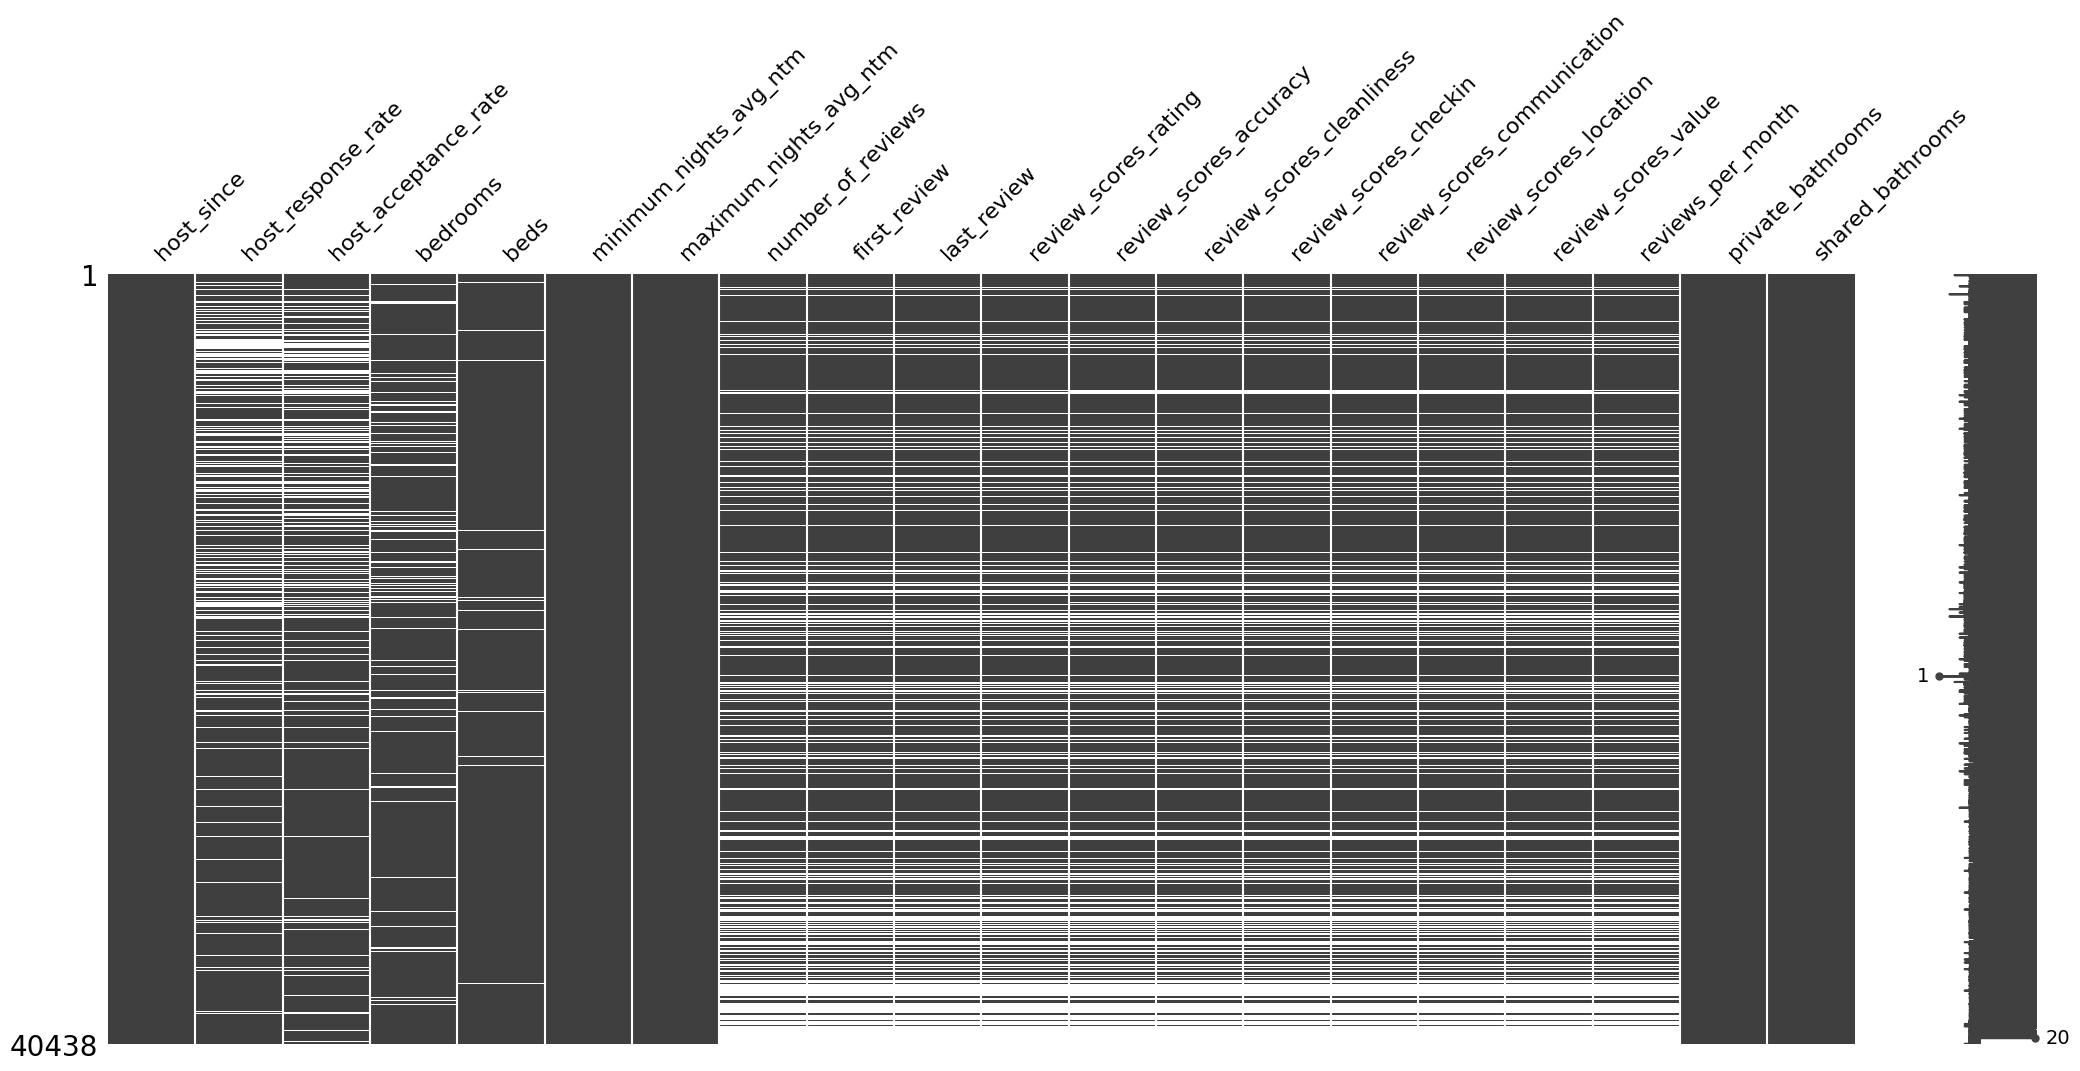

In [8]:
# check https://github.com/ResidentMario/missingno for more information
import missingno as msno

# create a new df with only the numerical columns and replace number_of_reviews that are 0 with NaN
listings_all = preprocessed_data.replace({'number_of_reviews': {0: np.nan}})
missing_cols = listings_all.columns[listings_all.isnull().any()]
print(missing_cols)

# Visualize missing values as a matrix
msno.matrix(listings_all[missing_cols])

<Axes: >

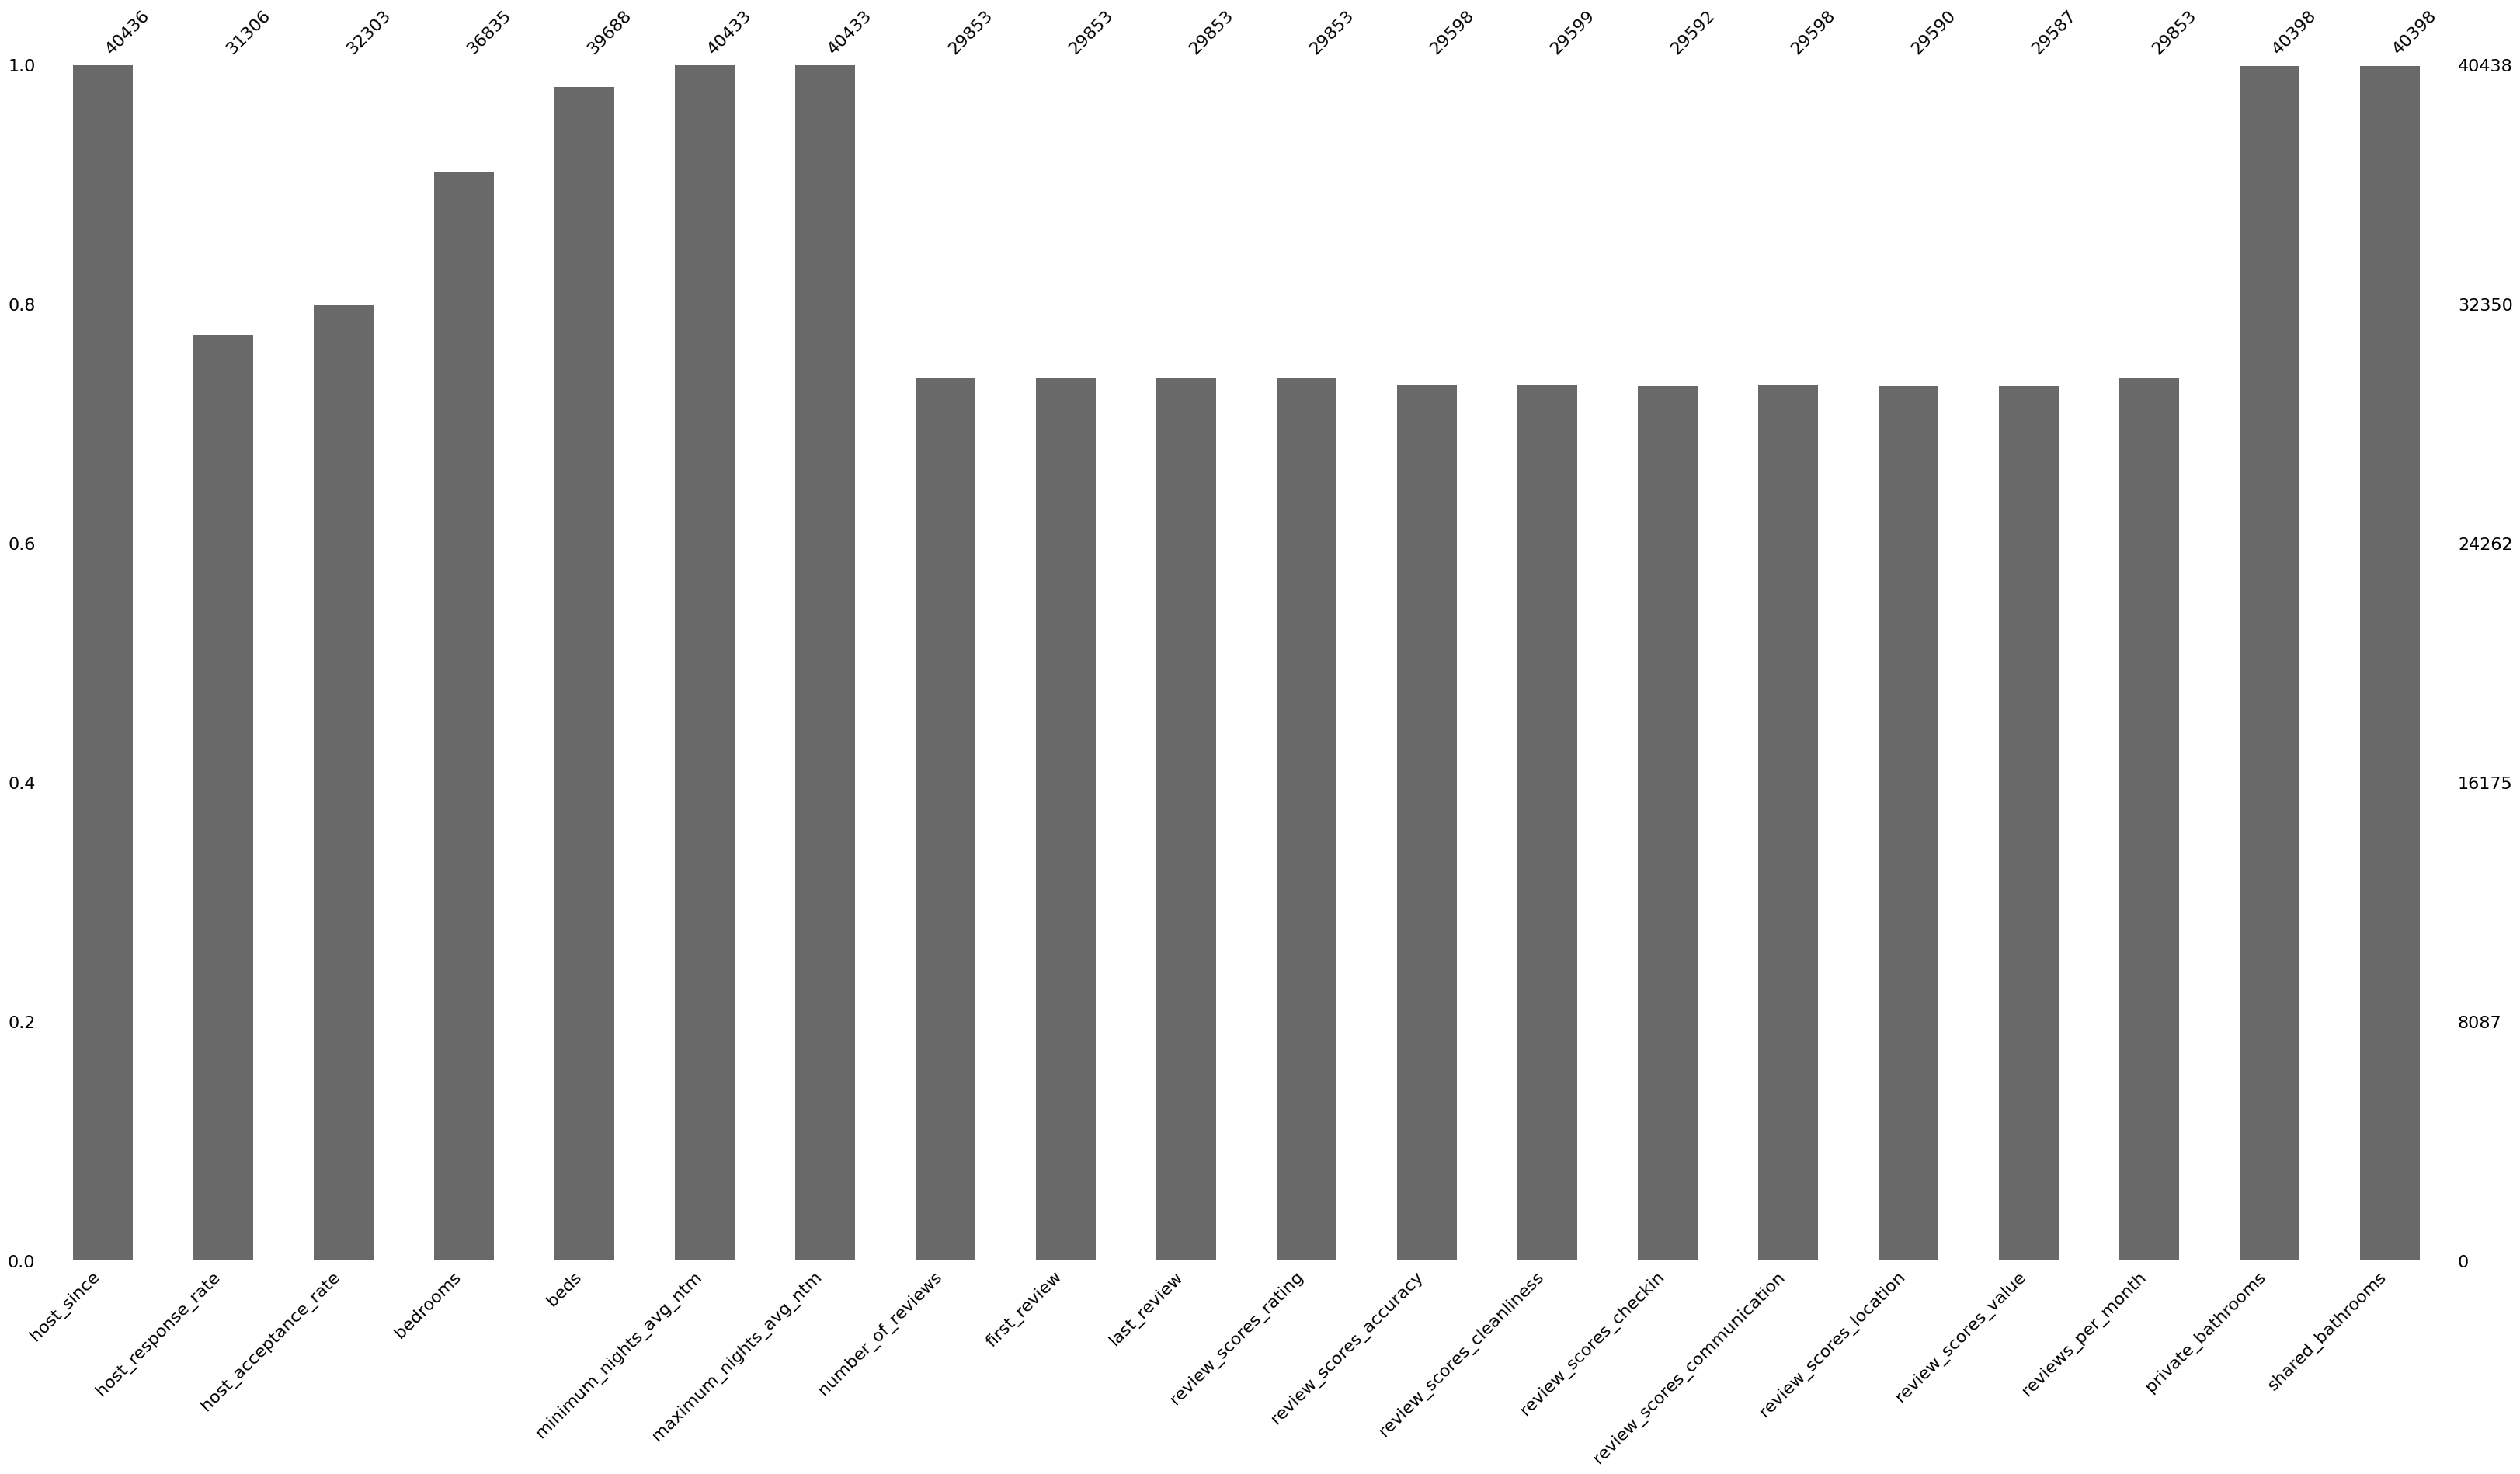

In [9]:
# show only columns with missing values
msno.bar(listings_all[missing_cols], figsize=(40, 20))


In [10]:

from sklearn.impute import SimpleImputer


def data_cleaning_pipeline(df):
    """
    Data imputation and cleaning.

    Args:
        df (pd.DataFrame): listings dataframe to process.
    
    Returns:
        df (pd.DataFrame): listings dataframe to with cleaned missing values.
    """
    review_related_cols = ['number_of_reviews', 'first_review', 'last_review', 'review_scores_rating',
                        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                        'review_scores_communication', 'review_scores_location', 'review_scores_value',
                        'reviews_per_month']
    columns_to_impute = ['host_response_rate', 'host_acceptance_rate', 'bedrooms']
    columns_to_drop_rows = ['beds', 'shared_bathrooms', 'private_bathrooms', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'host_since']

    # add columns to check if the listing has reviews
    df['has_reviews'] = (df['number_of_reviews'] > 0).astype(int)
    
    # impute missing values in the columns that are related to reviews
    df[review_related_cols] = df[review_related_cols].fillna(-1.00)
    
    # drop the rows with missing values
    df = df.dropna(subset=columns_to_drop_rows)
    
    # impute missings values with median values
    imputer = SimpleImputer(strategy='median')
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    
    return df


def check_missing_values(df):
    """
    Computes the percentage of missing values for each column in a given dataframe.

    Args:
        df (pd.DataFrame): dataframe to check the percentage of missing values.
    
    Returns:
        missing_values (pd.Series): percentage of missing values for each column.
    Note:
    For more details, check similar methods in https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
    """
    missing_values = df.apply(lambda x: sum(x.isnull()), axis=0)
    missing_values = missing_values[missing_values > 0] / df.shape[0] * 100
    return missing_values


# Apply preprocessing pipeline
preprocessed_data = data_cleaning_pipeline(preprocessed_data.copy())

# Check the percentage of missing values after imputation
print(check_missing_values(preprocessed_data))

# save preprocessed data in csv file
preprocessed_data.to_csv('../../data/processed/question_1/listings_preprocessed_onehot.csv.gz', index=False, compression='gzip')
preprocessed_data


/var/folders/kk/3n5ft7ts6fjgmmp11zwz_ybh0000gn/T/ipykernel_23033/2762536778.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])


Series([], dtype: float64)


,id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,Windowguards,Wineglasses,closet,open24hours,openspecifichours,pour-overcoffee,premiumcable,standardcable,yogamat,has_reviews
0,65467,2009-12-10,75.0,86.0,0,1,1,34.024380,-118.383740,2,...,0,0,0,0,0,0,0,0,0,0
1,206662,2009-08-25,75.0,38.0,1,1,1,34.104200,-118.347480,1,...,0,0,0,0,0,0,0,0,0,1
2,67089,2010-08-23,94.0,91.0,1,1,1,34.009850,-118.407980,3,...,0,0,0,0,0,0,0,0,0,1
3,210489,2010-02-01,100.0,98.0,0,1,1,34.053030,-118.394490,8,...,0,0,0,0,0,0,0,0,0,1
4,109,2008-06-27,100.0,98.0,0,1,1,33.983010,-118.386070,6,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40433,774860592421665035,2022-05-13,100.0,100.0,0,1,1,34.091006,-118.344620,2,...,0,0,0,0,0,0,0,0,0,0
40434,774864578948159716,2018-05-02,86.0,74.0,0,1,1,33.975508,-118.430657,4,...,0,0,0,0,0,0,0,0,0,0
40435,774866706304798119,2015-08-20,100.0,75.0,1,1,1,34.014228,-118.320888,3,...,0,0,0,0,0,0,0,0,0,0
40436,774872573559544018,2022-06-01,100.0,96.0,0,1,1,33.985194,-118.393408,4,...,0,1,0,0,0,0,0,0,0,0
